#  STA326——Assignment2

# Task 1: Distribution of Orders According to Reasons for Failure

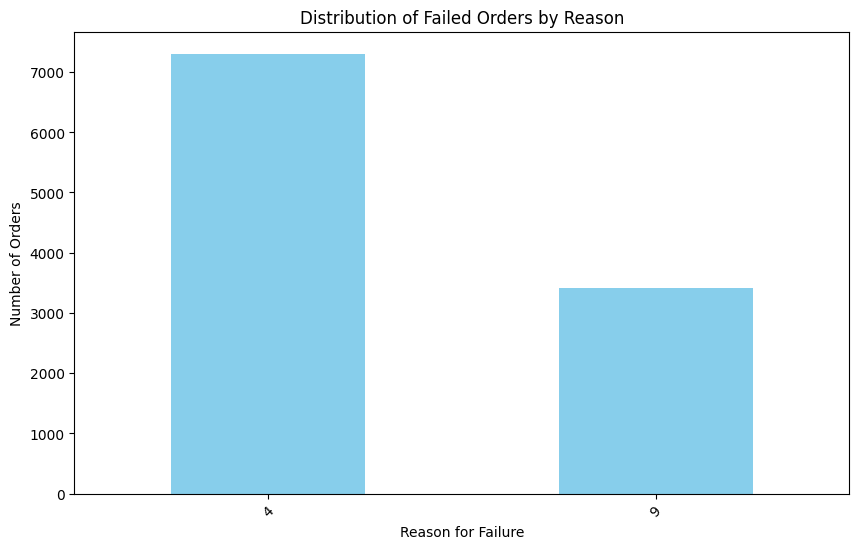

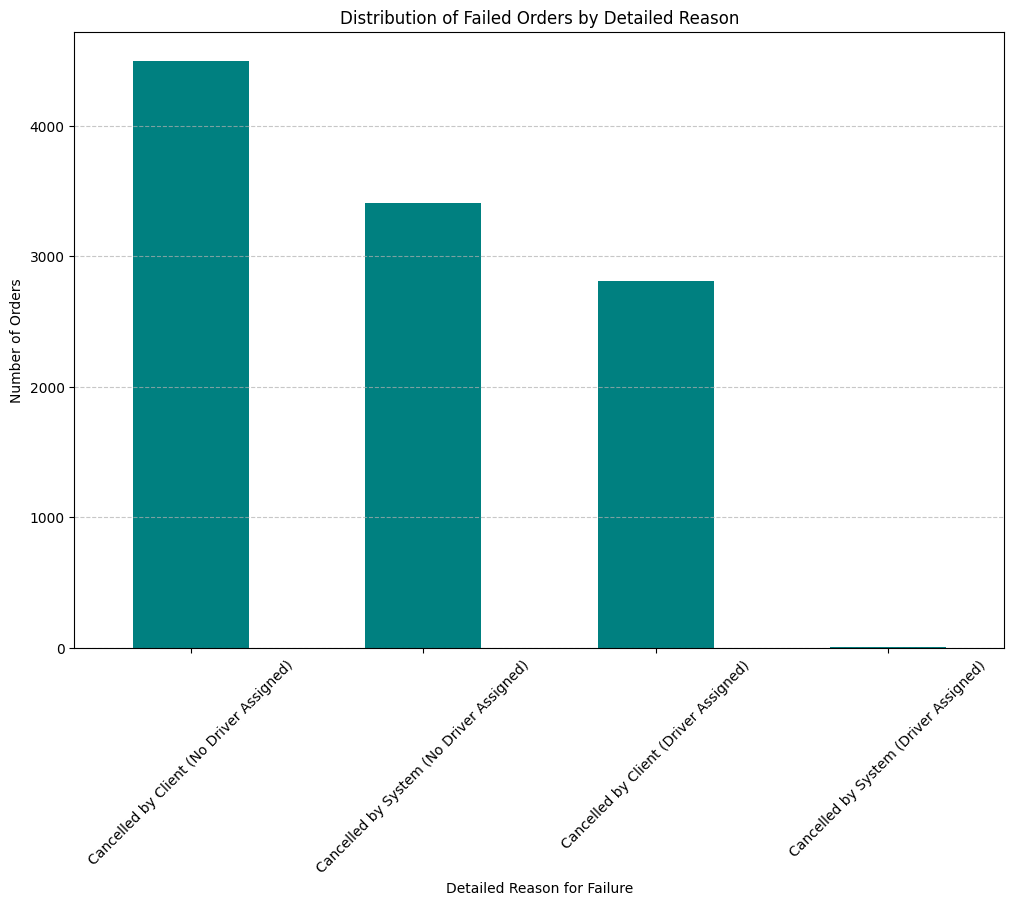

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
data_orders = pd.read_csv('datasets/data_orders.csv')
data_offers = pd.read_csv('datasets/data_offers.csv')

# 标记订单是否有分配司机
data_orders['driver_assigned'] = data_orders['is_driver_assigned_key'].apply(lambda x: 'Driver Assigned' if x == 1 else 'No Driver Assigned')
# 标记取消原因：客户取消或系统取消
data_orders['cancellation_source'] = data_orders['order_status_key'].map({
    4: 'Cancelled by Client',
    9: 'Cancelled by System'
})
data_orders['failure_reason'] = data_orders['order_status_key'].where(data_orders['order_status_key'].isin([4, 9]), 'Other')
# 绘制分布图
plt.figure(figsize=(10, 6))
data_orders['failure_reason'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Failed Orders by Reason')
plt.xlabel('Reason for Failure')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

# 合并取消原因和司机分配状态，创建新列标记详细原因
data_orders['detailed_failure_reason'] = data_orders['cancellation_source'] + ' (' + data_orders['driver_assigned'] + ')'
failure_counts = data_orders['detailed_failure_reason'].value_counts()

# 绘制分布图
plt.figure(figsize=(12, 8))
failure_counts.plot(kind='bar', color='teal')
plt.title('Distribution of Failed Orders by Detailed Reason')
plt.xlabel('Detailed Reason for Failure')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<font size=4>分析：</font>

从图一可以看出在未区分是否有司机分配的情况下，大部分失败订单都由顾客取消，约为由系统取消的两倍，可以分析出取消订单更容易由于顾客的原因，即客户个人因素是导致订单取消的主要原因；图二细化了取消订单的情况，可以看出“客户取消（未分配司机）”这一类别的订单数量最多，这意味大部分订单取消的情况集中在在司机未被分配到顾客由顾客把订单取消了，这可能表明客户可能是由于等待时间过长或是改变了出行计划这类原因最容易导致订单取消。相比之下，“系统取消（未分配司机）”和“系统取消（已分配司机）”的数量相对少一些，这表明可能是因为长时间匹配不到与顾客较近且空闲的司机、匹配系统的效率问题或其他技术原因导致的取消。而“客户取消（已分配司机）”的数量极少，可以看出在司机被分配后，系统基本上不会取消该订单，取消的原因绝大部分因为顾客本身原因。

# Task 2: Distribution of Failed Orders by Hours

<Figure size 1200x600 with 0 Axes>

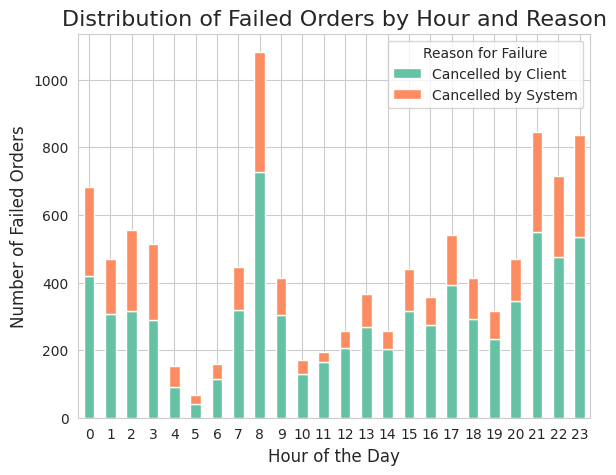

In [9]:
import seaborn as sns

# 转换时间格式并提取小时信息
data_orders['hour_of_day'] = pd.to_datetime(data_orders['order_datetime']).dt.hour

# 分组计算每小时的失败订单数量
hourly_distribution = data_orders.groupby(['hour_of_day', 'failure_reason']).size().unstack(fill_value=0)

# 设置背景风格
sns.set_style("whitegrid")

# 绘制堆叠柱状图
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2")
hourly_distribution.plot(kind='bar', stacked=True, color=colors)
plt.title('Distribution of Failed Orders by Hour and Reason', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Failed Orders', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Reason for Failure', fontsize=10)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

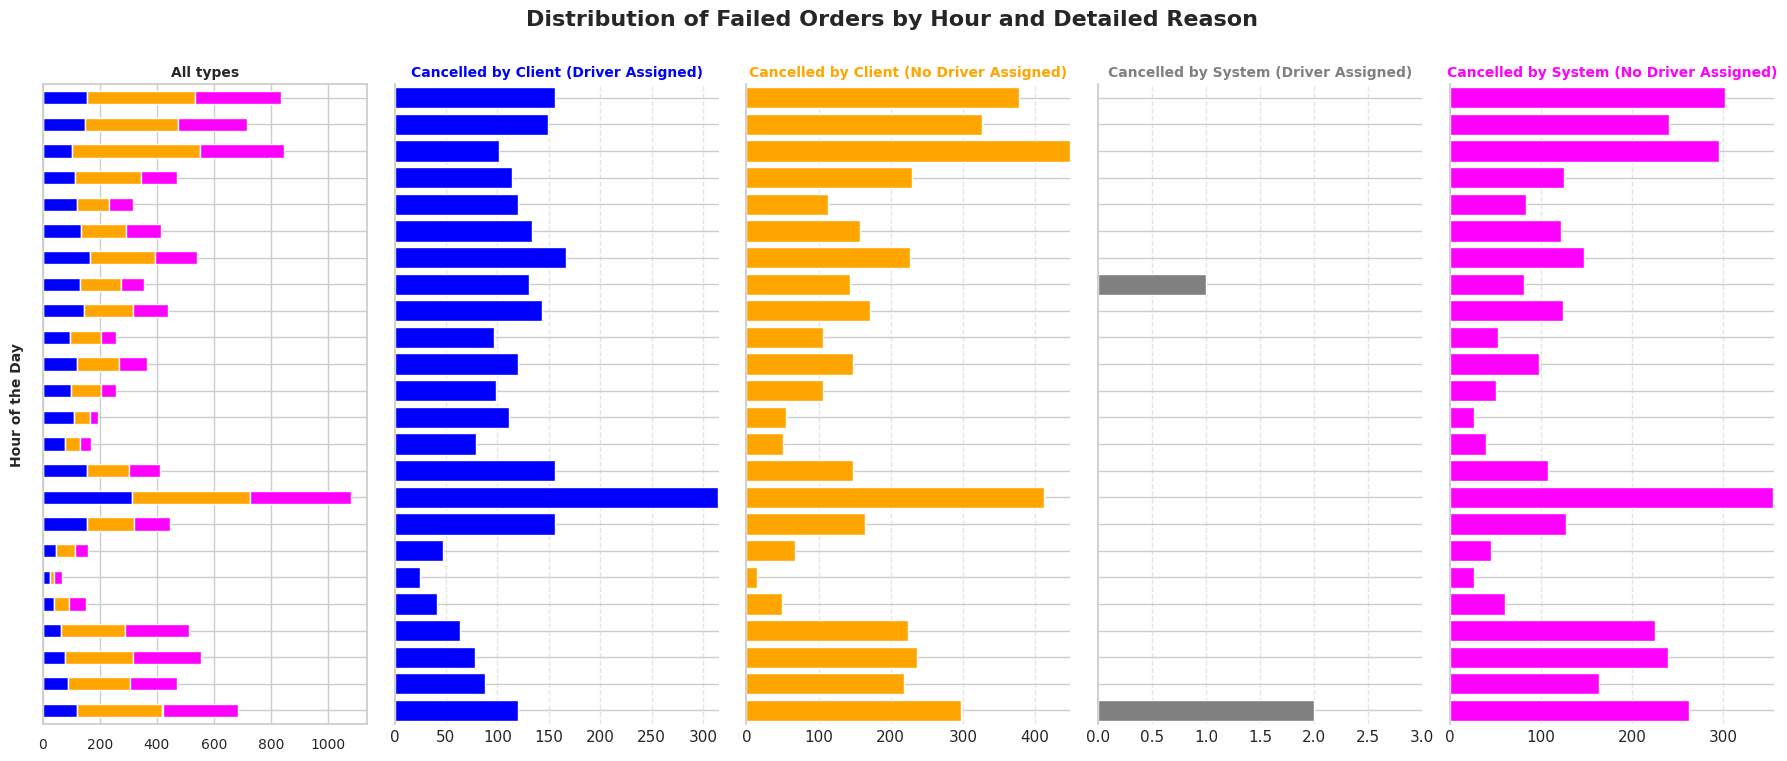

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
# 按小时和详细失败原因分组计算失败订单数
hourly_distribution = data_orders.groupby(['hour_of_day', 'detailed_failure_reason']).size().unstack(fill_value=0)

# 设定Seaborn样式
sns.set_style("whitegrid")
colors = ['blue', 'orange', 'grey', 'fuchsia', 'skyblue']
fig, axes = plt.subplots(nrows=1, ncols=len(hourly_distribution.columns)+1, figsize=(18, 8), sharey=True)
# 在第一个子图上绘制总体失败订单的堆叠横向条形图
hourly_distribution.plot(kind='barh', stacked=True, color=colors, ax=axes[0], legend=False) 
axes[0].set_title('All types',  fontweight='bold', fontsize=10)
axes[0].set_ylabel('Hour of the Day',  fontweight='bold', fontsize=10)
axes[0].tick_params(axis='y', labelrotation=0)
axes[0].tick_params(axis='x', labelsize=10)
# 在剩余子图中为每个详细原因绘制横向条形图
for ax, (column, color) in zip(axes[1:], zip(hourly_distribution.columns, colors)):
    ax.barh(hourly_distribution.index, hourly_distribution[column], color=color)
    ax.set_title(column, fontweight='bold', color=color,fontsize=10)
    ax.set_xlim(0, hourly_distribution[column].max() + 1) 
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)  
    ax.spines['bottom'].set_visible(False)  
    ax.tick_params(axis='both', which='both', length=0) 
    ax.grid(axis='x', linestyle='--', alpha=0.5) 

# 仅在第一个子图上显示y轴标签
for ax in axes[1:]:
    ax.set_yticklabels([])
fig.suptitle('Distribution of Failed Orders by Hour and Detailed Reason', fontsize=16, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

<font size=4>分析：</font>

1.可以从图中看出在早晨8点的失败订单最多，而且由顾客取消的和由系统取消的订单都最多，相对其他时间段是一个极为明显的高峰，这是一个典型的上班高峰时段，打车的顾客会最多。在这个时候取消的订单，可能是由于：

<font size=1>排队时长：由于打车的人数太多导致顾客迟迟等不到接单的司机，进而取消订单。</font>

<font size=1>交通高峰：在交通高峰期间，可能会出现交通拥堵情况，司机难以按时到达，进而导致系统取消订单。</font>

<font size=1>匹配困难：在需求激增的早高峰，系统可能难以及时为所有订单找到合适的司机，从而导致了订单被取消。</font>。

2.另一段高峰在晚间的21点到23点，这个时间段通常是人们结束工作日程，进行社交活动或回家的时候，出行需求增加。由顾客和系统取消的订单的数量在这段时间都明显增多，除了第一点里列出的原因外，由于晚上虽然出行人数也多，但是通常没有赶早班的时候紧急，导致其他原因如：

<font size=1>出行计划：晚上人们可能因为工作加班、社交活动或其他临时变动而改变出行计划，这导致了在分配司机前取消订单的情况频发。</font>

<font size=1>服务选择：晚间是其他出行服务竞争激烈的时段，顾客在不赶时间的情况下可能在对比后选择了如地铁等更快或更经济的出行方式。</font>

3.在不太繁忙的取消订单较少的时间段（如凌晨4-6点，10点到12点等），顾客取消的订单往往较少，而由系统取消的订单通常远远大于顾客取消的订单,可能有以下原因:

<font size=1>系统问题：系统可能存在缺陷，比如错误的匹配算法或技术故障，导致即使在需求不高的时候也无法有效地将订单分配给司机。</font>

<font size=1>在线司机数量：在需求较低的时段，可能有更少的司机在线等待订单，系统因此可能找不到可用的司机来接单。且在在线司机数较少的时候，系统可能对未能及时配对司机和顾客的订单设置了超时机制，如果配对超过特定时间没有成功，订单将自动被取消。</font>



# Task3：Average Time to Cancellation by Hour

/tmp/ipykernel_3294/1052547317.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_orders['cancellation_time_minutes'], shade=True)


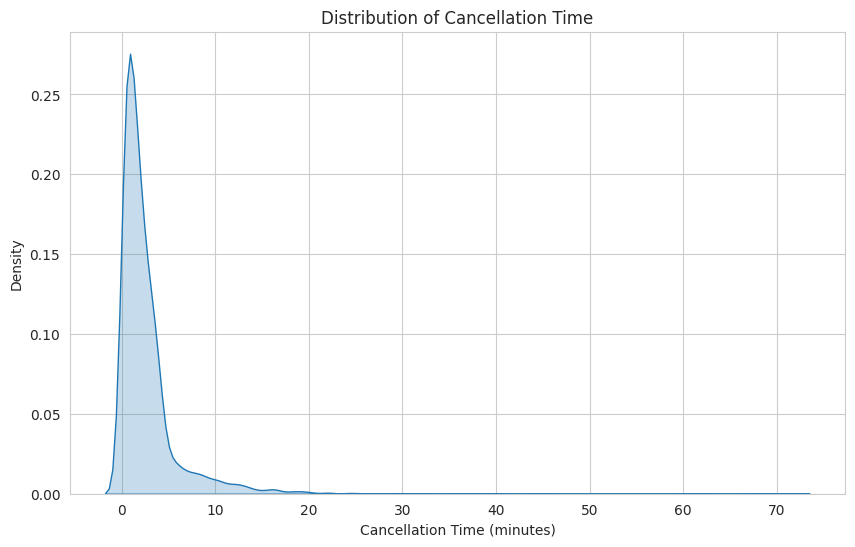

In [26]:
#先查看取消订单时间的分布
import numpy as np
from scipy import stats
# 把取消前的平均等待时间转换为分钟，使得更直观
data_orders['cancellation_time_minutes'] =  data_orders['cancellations_time_in_seconds'] / 60
# 创建密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(data_orders['cancellation_time_minutes'], shade=True)
plt.title('Distribution of Cancellation Time')
plt.xlabel('Cancellation Time (minutes)')
plt.ylabel('Density')
plt.show()

/tmp/ipykernel_3294/2837848462.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_3294/2837848462.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


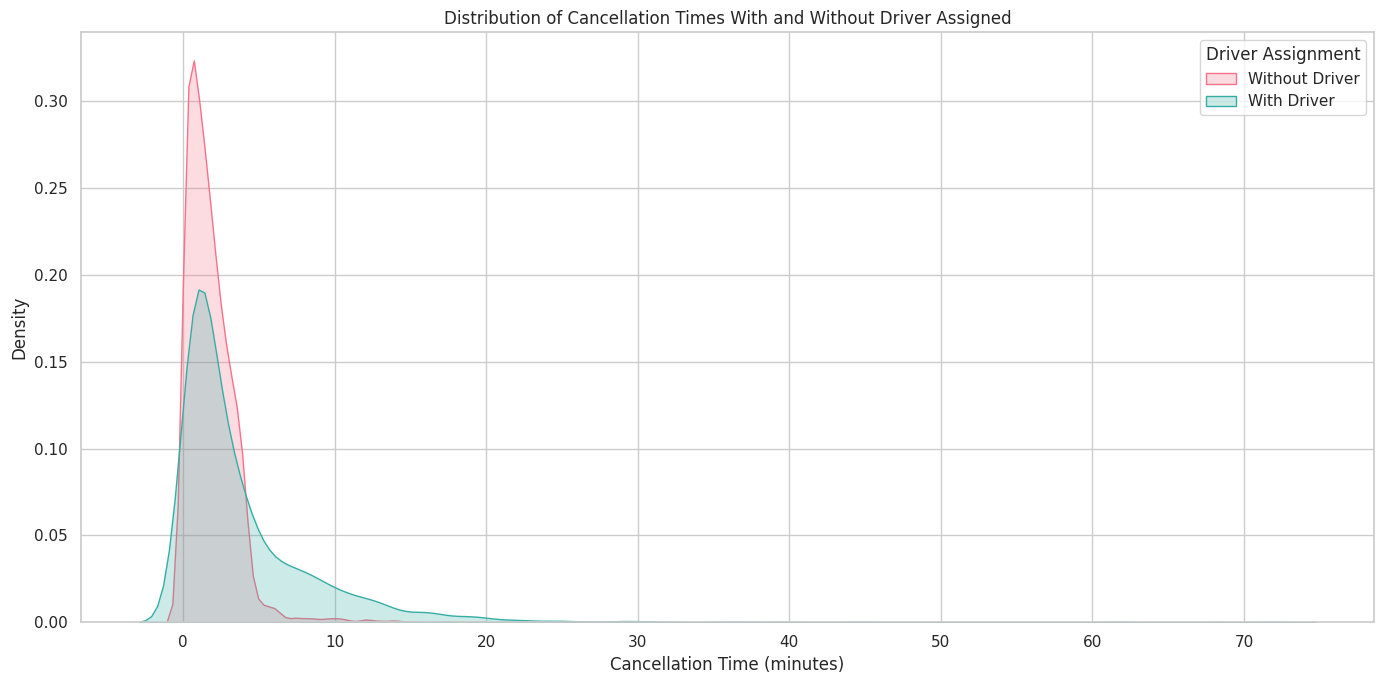

In [47]:
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 2)
plt.figure(figsize=(14, 7))
sns.kdeplot(
    data=data_orders[data_orders['driver_assigned'] == 'Without Driver']['cancellation_time_minutes'],
    label='Without Driver',
    shade=True,
    color=palette[0]
)
sns.kdeplot(
    data=data_orders[data_orders['driver_assigned'] == 'With Driver']['cancellation_time_minutes'],
    label='With Driver',
    shade=True,
    color=palette[1]
)
plt.title('Distribution of Cancellation Times With and Without Driver Assigned')
plt.xlabel('Cancellation Time (minutes)')
plt.ylabel('Density')
plt.legend(title='Driver Assignment')
plt.tight_layout()
plt.show()

时间特别小的订单通常为顾客误触而即时取消的订单（根据生活经验，我们这里选取小于5秒的订单），对我们这个task的研究意义不大，同时根据上面的取消订单时长分布图，若超过20分钟的订单可以判断为离群值，其次根据生活经验超过20分钟的订单通常为忘记取消订单的情况，对我们这个task的研究意义不大，于是在下面过滤掉这两种情况。

ps：也可以用IQR来去除离群值，经尝试最后的结果几乎不变

<Figure size 1500x700 with 0 Axes>

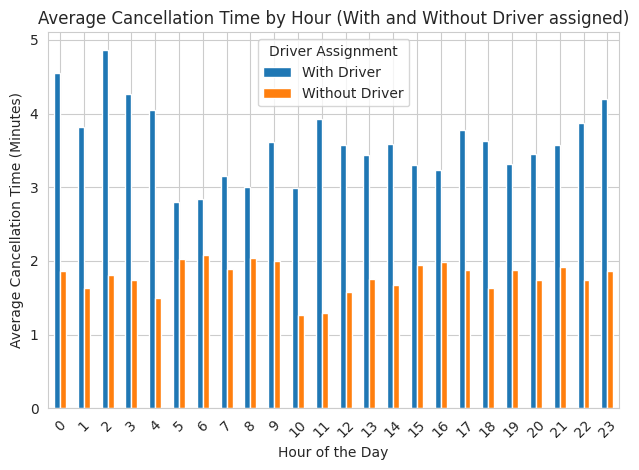

In [33]:
# 去掉时间小于5秒的和超过20分钟的订单
filtered_orders = data_orders[(data_orders['cancellations_time_in_seconds'] >= 5) & 
                                   (data_orders['cancellations_time_in_seconds'] <= 20*60)]

# 按小时和司机分配情况分组，计算平均取消时间
avg_cancellation_time_by_hour = filtered_orders.groupby(['hour_of_day', 'driver_assigned'])['cancellation_time_minutes'].mean().unstack()
plt.figure(figsize=(15, 7))
avg_cancellation_time_by_hour.plot(kind='bar')
plt.title('Average Cancellation Time by Hour (With and Without Driver assigned)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (Minutes)')
plt.xticks(rotation=45)
plt.legend(title='Driver Assignment')
plt.tight_layout()
plt.show()

<Figure size 1500x700 with 0 Axes>

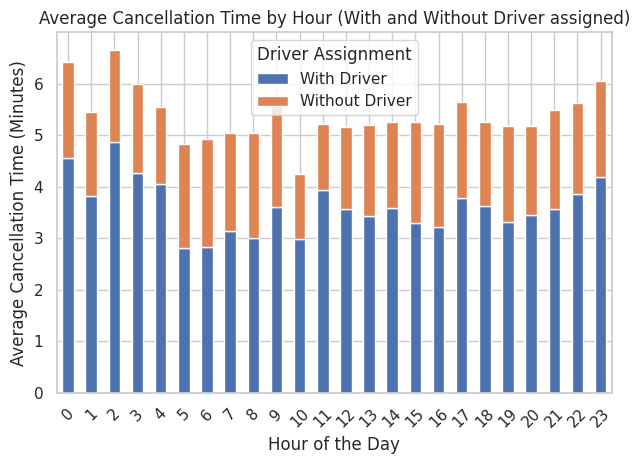

In [79]:
plt.figure(figsize=(15, 7))
avg_cancellation_time_by_hour.plot(kind='bar', stacked=True)
plt.title('Average Cancellation Time by Hour (With and Without Driver assigned)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (Minutes)')
plt.xticks(rotation=45)
plt.legend(title='Driver Assignment')
plt.tight_layout()
plt.show()

<font size=4>分析：</font>

1.有司机分配的订单取消时间的平均值普遍高于没有司机分配的订单。这意味着一旦订单被司机接受，客户可能会更愿意等待一段时间，或者需要更多时间来取消订单。

2.在凌晨的时段（23点-4点），有司机分配的订单的取消时间平均值更高，这可能反映了夜间出行计划的不确定性，或者在晚上客户更可能改变主意。

3.在上午的时间段(5点-10点），无论是否分配了司机，取消时间的平均值都相对较低，这可能是因为早晨时间紧迫，客户可能更快做出决定。

4.在晚上时间段（19点-0点），取消时间的平均值开始上升，尤其是有司机分配的订单。这可能是由于晚上的出行需求增加，或者因为晚上客户可能更倾向于改变出行计划。

# Task4: Distribution of Average ETA（time before order arrival）by Hours

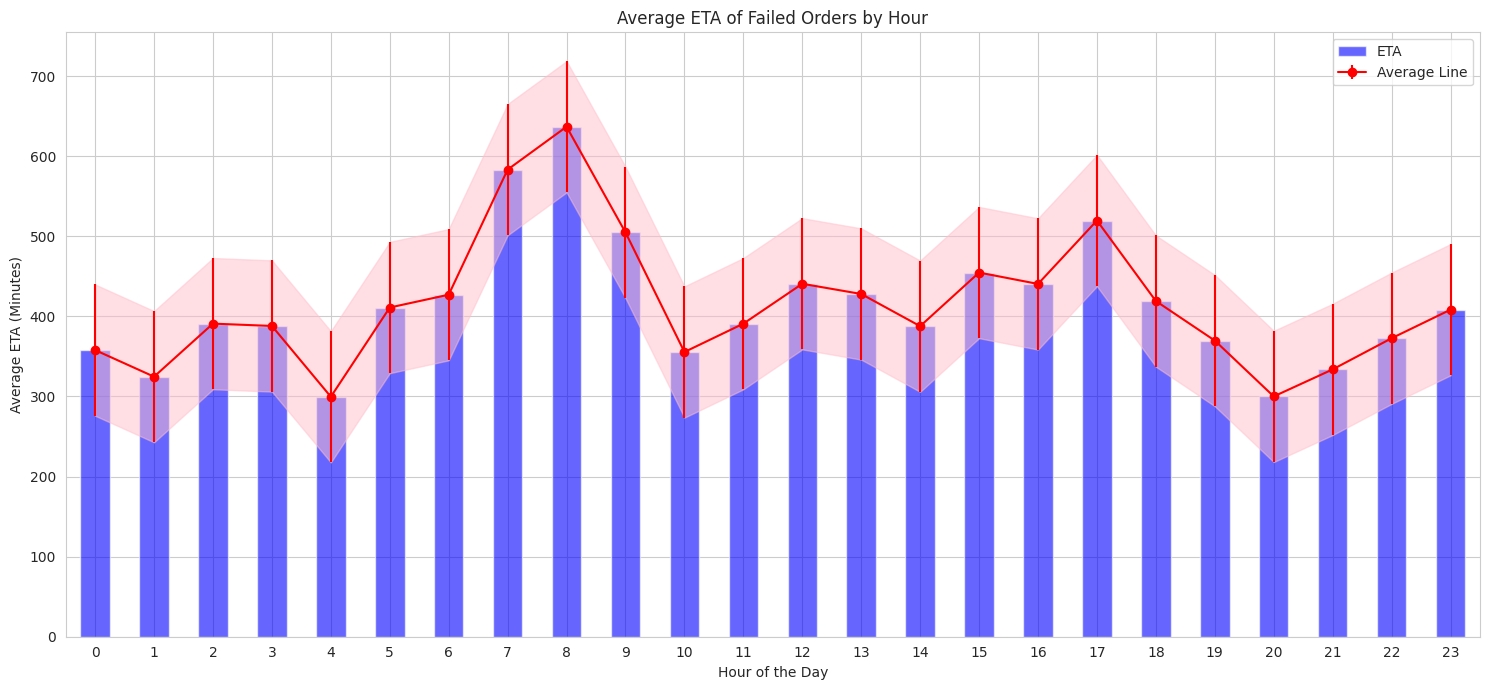

In [42]:
from matplotlib.ticker import MaxNLocator
# 转换时间格式并提取小时信息
data_orders['hour_of_day'] = pd.to_datetime(data_orders['order_datetime']).dt.hour

# 按小时分组计算平均ETA
average_eta_by_hour = data_orders.groupby('hour_of_day')['m_order_eta'].mean()

# 计算平均值和标准差
avg = average_eta_by_hour.mean()
std = average_eta_by_hour.std()

# 绘制条形图
plt.figure(figsize=(15, 7))
ax = average_eta_by_hour.plot(kind='bar', color='blue', alpha=0.6, label='ETA')

# 在条形图上绘制折线图
average_eta_by_hour.plot(kind='line', color='red', marker='o', yerr=std, label='Average Line')

# 填充标准差范围
ax.fill_between(average_eta_by_hour.index, average_eta_by_hour - std, average_eta_by_hour + std, color='pink', alpha=0.5)
plt.title('Average ETA of Failed Orders by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (Minutes)')
plt.legend()
plt.tight_layout()
plt.show()

<font size=4>分析：</font>

由常识可以推测平均ETA的高低应该与顾客对出租车的需求有关系，而且可以看出平均ETA的时段的变化有明显的趋势和峰值，则选择按时间段进行分析

1.早高峰（6点-9点）：在这个时间段平均ETA有一个上升的峰值，可以分析出由于早高峰人们通勤使得司机的需求增加，此时可用的空闲司机数量有限，导致客户需要更长时间等待司机接单。

2.午夜（1点-5点）与工作时间（10点至16点）：在这两个个阶段，ETA都呈现出相对较低和平稳的趋势，且平均值也都相对较低，可以分析出这两个时间段顾客的需求不高且较平稳，司机供给与需求比较匹配，顾客通常不需要等待太长时间，司机接单的效率相对较高。

3.晚高峰（17点）：17点的平均ETA明显比附近时间段高，可以分析出通常的下班时间都为下午五点左右，与早高峰类似，此时打车需求量较大，导致客户需要更长时间等待司机接单。

4.晚间时间（20点-23点）：在20点出现明显的平均ETA低峰，而从20点到23点逐渐上升，可以分析这个时间段人们大部分都在吃晚饭或者进行晚上的娱乐放松活动，所以对打车需求量小，在八点以后人们渐渐结束活动返回家中，于是用车量逐渐增加，平均ETA时间增高。

可以总结出平均ETA的高低与顾客对出租车的需求量相关。早高峰和晚高峰时段由于通勤需求增加，平均ETA较高；而午夜和工作时间段由于需求较低且供给与需求相匹配，平均ETA较低稳定。晚间时间段由于人们活动结束返回家中，用车量增加，平均ETA逐渐上升。

# Task5: Hexagons of order

In [4]:
import pandas as pd
import h3
import folium
from branca.colormap import linear

# 将纬度和经度转换为分辨率为8的h3六边形编码
data_orders['hex_id'] = data_orders.apply(
    lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

# 统计每个六边形内的订单数量并排序
order_hex_counts = data_orders['hex_id'].value_counts().reset_index()
order_hex_counts.columns = ['hex_id', 'order_count']
order_hex_counts.sort_values('order_count', ascending=False, inplace=True)

# 计算累积百分比
order_hex_counts['cumulative_percentage'] = order_hex_counts['order_count'].cumsum() / order_hex_counts['order_count'].sum()

# 找到包含80%订单的六边形
cutoff = order_hex_counts[order_hex_counts['cumulative_percentage'] <= 0.8]
print(f"符合条件的六边形数量：{len(cutoff)}")

符合条件的六边形数量：23


In [5]:
def visualize_hexagons(hexagons, order_counts, folium_map=None):
    # 创建一个从浅色到深色的多彩颜色映射
    max_count = max(order_counts.values())
    colormap = linear.Spectral_11.scale(0, max_count)
    lat, lng = [], []
    for hex in hexagons:
        # 获取六边形的多边形表示
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        # 计算多边形的平均坐标以确定地图中心
        lat.extend([coord[0] for coord in polyline])
        lng.extend([coord[1] for coord in polyline])
        if folium_map is None:
            folium_map = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
        color = colormap(order_counts[hex])  # 根据订单数量获取颜色
        my_polygon = folium.Polygon(locations=polyline, weight=2, color=color, fill=True, fill_color=color, fill_opacity=0.6)
        folium_map.add_child(my_polygon)
    colormap.caption = 'Order Density'
    folium_map.add_child(colormap)

    return folium_map

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [11]:
hex_counts =cutoff.set_index('hex_id')['order_count'].to_dict()
m = visualize_hexagons(list(hex_counts.keys()), hex_counts)
m.save('hexagons_map.html') 
display(m) 

<font size=4>分析：</font>

1.数据生成的六边形都在英国英格兰伯克郡。

2.订单最多的也就是最深的蓝色六边形区域是伯克郡车站所在的位置，可以分析在火车站人流量较多，需要叫车的人较多，使得取消订单的数量提高。另外由于车站附近交通方式多样，在车站附近也便于人们转变交通方式，所以导致取消订单的数随之变多。

3.在蓝色区域右下方的几个黄色区域也是订单数量较高的区域。观察这些区域可以发现道路密集，而红色区域的订单数量较低，道路相对稀疏。这表明在道路密集的地方，顾客更容易叫到车，因此订单密度更高。

4.通过在高德地图进行搜索，可以发现黄色区域中存在许多风景区。这可以解释为什么在这些地区取消订单的数量较高。由于游客数量较多，需要叫车的人也增加，因此在风景区叫车通常更困难，从而导致取消订单的数量上升。